# Consignas

1)Desarrollar un sistema de recomendación de prestadores a partir de un modelo K-Nearest Neighbours.

Teniendo en cuenta que el perfil de los pacientes en cada especialidad muestra una marcada diferencia, desarrollar un modelo de recomendación para cada especialidad.
Utilizar modelo sklearn.neighbors.KNeighborsClassifier. La variable target será el id_prestador.
En línea con el objetivo planteado para el proyecto, el dataset de entrenamiento y validación del modelo serán aquellos prestadores que muestran altas calificaciones y un nivel de demanda medio y alto. Las altas calificaciones nos aseguran que los prestadores a recomendar brindan un buen servicio. El nivel de demanda medio/alto nos asegura que las calificaciones son representativas estadísticamente.


# Importación de librerías

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
import operator
import scipy as sp
from sklearn.neighbors import KNeighborsClassifier

pd.options.display.float_format = "{:,.4f}".format

# Funciones

In [114]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Importación de datasets

In [115]:
df=pd.read_csv('../Data/df_procesado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 33 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   int64

In [116]:
df.head(2)

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,especialidad_prestador_encoded_PEDIATRIA,edad_cat_mayor,edad_cat_medio,edad_cat_pediatrico,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.6667,1,81,0.5308,1,0,1,...,0,1,0,0,1,0,0,0,0,1
1,2,100000,200000,0.5556,1,81,0.5308,1,0,1,...,0,1,0,0,1,0,0,0,0,1


### Análisis de demanda de prestadores

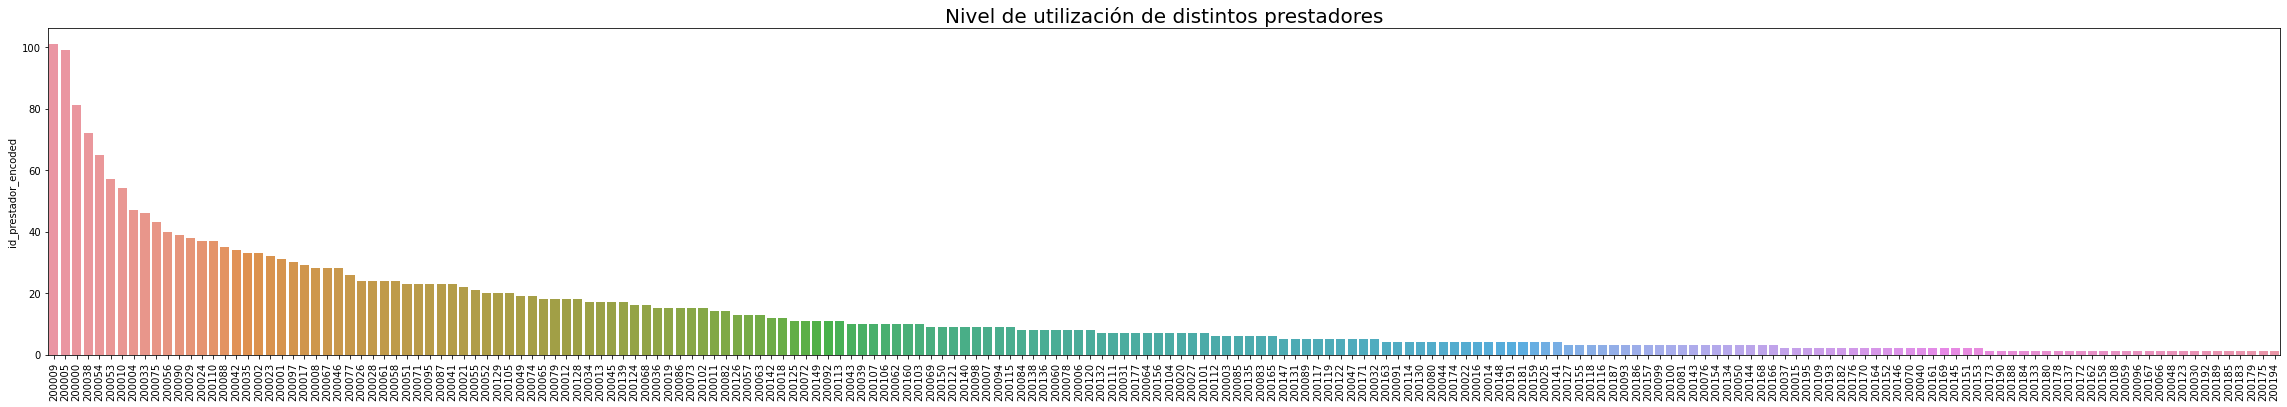

In [117]:
plt.figure(figsize=(40,6))
sns.barplot(x=df.id_prestador_encoded.value_counts().index,y=df.id_prestador_encoded.value_counts(),
           order=df.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores",fontsize=20)
plt.show()

Partiendo del análisis realizado en los laboratorios anteriores, tenemos muchos prestadores que han sido utilizados pocas veces, mientras que hay pocos que han sido utilizados muchas veces.
Vamos a hacer una selección basándonos en medidas de tendencia central de la distribución anterior

In [118]:
df.id_prestador_encoded.value_counts().describe().reset_index()

,index,id_prestador_encoded
0,count,196.0000
1,mean,12.7551
2,std,16.3249
3,min,1.0000
4,25%,3.0000
5,50%,7.0000
6,75%,17.0000
7,max,101.0000


Vamos a filtrar utilizando el percentil 0.42

In [119]:
percetil_42=df.id_prestador_encoded.value_counts().quantile(0.42)
prestadores_interes=df.id_prestador_encoded.value_counts()[df.id_prestador_encoded.value_counts()>percetil_42].index

In [120]:
df_filtrado=df[df.id_prestador_encoded.isin(prestadores_interes)]
df_filtrado.shape

(2272, 33)

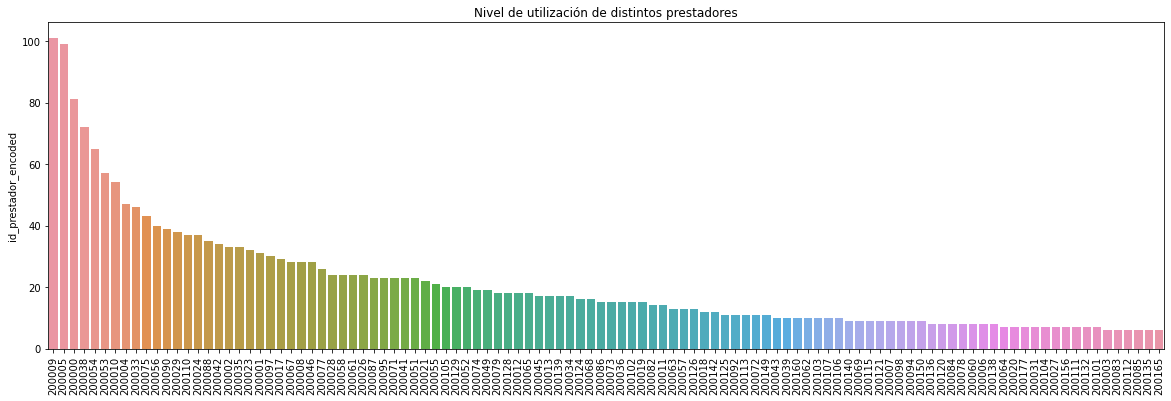

In [121]:
plt.figure(figsize=(20,6))
sns.barplot(x=df_filtrado.id_prestador_encoded.value_counts().index,y=df_filtrado.id_prestador_encoded.value_counts(),
           order=df_filtrado.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores")
plt.show()

### Análisis de calificaciones

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


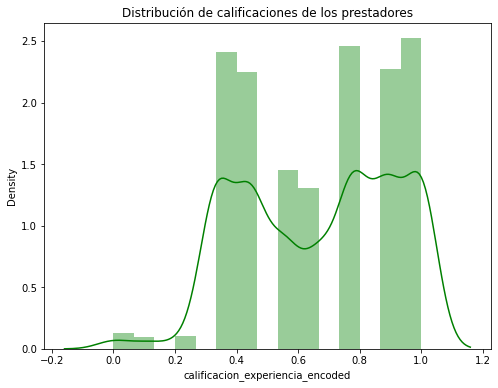

In [122]:
plt.figure(figsize=(8,6))
sns.distplot(df_filtrado.calificacion_experiencia_encoded,color='g')
plt.title("Distribución de calificaciones de los prestadores")
plt.show()

In [123]:
df_filtrado.calificacion_experiencia_encoded.describe().reset_index()

,index,calificacion_experiencia_encoded
0,count,"2,272.0000"
1,mean,0.6647
2,std,0.2486
3,min,0.0000
4,25%,0.4444
5,50%,0.6667
6,75%,0.8889
7,max,1.0000


Vamos a filtrar utilizando el percentil 0.405

In [124]:
percentil_0405=df_filtrado.calificacion_experiencia_encoded.quantile(0.405)

In [125]:
df_filtrado=df_filtrado[df_filtrado.calificacion_experiencia_encoded>percentil_0405]

In [126]:
df_filtrado.shape

(1297, 33)

Nos quedamos con un total de 1297 registros de pacientes para las 3 especialidades. Este grupo de datos considera a los prestadores mas demandados y que posean calificaciones más aceptables.

## Filtrado de variables no importantes

En un primer análisis se tendrán en cuenta todas las variables adicionales. Solamente se quitarán las que no son necesarias para el proceso de modelado

In [127]:
df_filtrado.columns

Index(['id_consumo_encoded', 'id_socio_encoded', 'id_prestador_encoded',
       'calificacion_experiencia_encoded', 'id_zona_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI',
       'especialidad_prestador_encoded_CLINICA MEDICA',
       'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ',
       'especialidad_prestador_encoded_PEDIATRIA', 'edad_cat_mayor',
       'edad_cat_medio', 'edad_cat_pediatrico', 'categoria_prestador_gold',
       'categoria_prestador_silver', 'categoria_prestador_standard',
       'categoria_socio

In [128]:
df_filtrado.drop(['id_consumo_encoded','edad_encoded','id_zona_encoded'],axis=1,inplace=True)

## Especialidad Clínica Médica

Filtramos los prestadores según la especialidad clínica médica

In [129]:
df_clinica=df_filtrado[df_filtrado['especialidad_prestador_encoded_CLINICA MEDICA']==1]
df_clinica.drop(['especialidad_prestador_encoded_CLINICA MEDICA',
       'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ',
       'especialidad_prestador_encoded_PEDIATRIA',
       'categoria_prestador_gold', 'categoria_prestador_silver',
       'categoria_prestador_standard', 'categoria_socio_gold',
       'categoria_socio_silver', 'categoria_socio_standard'],axis=1,inplace=True)

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [130]:
df_clinica

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,...,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Otro,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_mayor,edad_cat_medio,edad_cat_pediatrico
0,100000,200000,0.6667,0.5308,1,0,1,0,0,0,...,1,0,0,0,1,0,1,1,0,0
2,100002,200000,0.6667,0.5846,1,0,0,1,0,1,...,0,0,0,1,0,1,0,0,1,0
3,100010,200000,0.6667,0.5231,1,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
4,100017,200000,0.6667,0.5385,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
7,100035,200000,0.6667,0.4154,1,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,101492,200129,1.0000,0.3846,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0
2257,101682,200129,0.8889,0.5077,1,0,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
2258,101696,200129,0.8889,0.0385,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
2259,101710,200129,0.7778,0.5923,1,0,1,0,0,1,...,0,0,0,0,1,0,1,0,1,0


Existen varios registros de los mismos pacientes para un mismo médico, por lo cual vamos a unificar todos los registros de estos pacientes.

In [131]:
df_clinica[df_clinica.id_socio_encoded.duplicated()]

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,...,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Otro,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_mayor,edad_cat_medio,edad_cat_pediatrico
15,100332,200000,0.6667,0.5615,0,1,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
27,100610,200000,0.6667,0.6077,1,0,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0
67,101460,200000,0.6667,0.3462,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
71,101475,200000,0.6667,0.4154,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
87,100594,200001,1.0000,0.4385,0,1,0,0,1,1,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,101062,200071,0.7778,0.0308,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0
1585,101784,200071,0.7778,0.3231,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1
1955,100791,200097,1.0000,0.1154,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
2251,101097,200129,1.0000,0.1231,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0


Tenemos 80 registros de pacientes que se corresponden con los mismos pacientes y que por lo tanto deben ser eliminados para no sesgar el modelo. A continuación obtenemos los ids y evaluamos cada uno de los registros para obtener un registro representativo de cada uno de sus consumos.

In [132]:
ids_socios_duplicados=df_clinica[df_clinica.id_socio_encoded.duplicated()].sort_values('id_socio_encoded').id_socio_encoded.unique()
df_duplicados=df_clinica[df_clinica.id_socio_encoded.isin(ids_socios_duplicados)]

In [133]:
df_duplicados

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,...,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Otro,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_mayor,edad_cat_medio,edad_cat_pediatrico
14,100332,200000,0.6667,0.5615,0,1,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
15,100332,200000,0.6667,0.5615,0,1,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
26,100610,200000,0.6667,0.6077,1,0,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0
27,100610,200000,0.6667,0.6077,1,0,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0
66,101460,200000,0.6667,0.3462,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,100791,200097,1.0000,0.1154,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
2250,101097,200129,1.0000,0.1231,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
2251,101097,200129,1.0000,0.1231,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
2252,101263,200129,1.0000,0.2077,1,0,1,0,0,0,...,1,0,0,0,1,0,1,1,0,0


In [134]:
print("Hay {} pacientes con registros duplicados".format(ids_socios_duplicados.shape[0]))

Hay 64 pacientes con registros duplicados


Vamos a verificar si todas las variables, a excepción de calificacion_experiencia_encoded, se mantienen constantes

In [135]:
columns=[k for k in df_duplicados.columns if 'calificacion_experiencia_encoded' not in k]

df_duplicados[df_duplicados.duplicated(subset=columns)]

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,...,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Otro,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_mayor,edad_cat_medio,edad_cat_pediatrico
15,100332,200000,0.6667,0.5615,0,1,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
27,100610,200000,0.6667,0.6077,1,0,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0
67,101460,200000,0.6667,0.3462,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
71,101475,200000,0.6667,0.4154,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
87,100594,200001,1.0000,0.4385,0,1,0,0,1,1,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,101062,200071,0.7778,0.0308,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0
1585,101784,200071,0.7778,0.3231,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1
1955,100791,200097,1.0000,0.1154,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
2251,101097,200129,1.0000,0.1231,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0


Efectivamente todas las variables estan duplicadas para estos pacientes. Es de esperar que hayan puesto distintas calificaciones, por lo cual reemplazaremos la variable calificacion_experiencia_encoded por el promedio obtenido en todas las visitas. Finalmente eliminamos los duplicados

In [136]:
df_clinica['calificacion_experiencia_encoded']=df_clinica.groupby(['id_socio_encoded'])['calificacion_experiencia_encoded'].transform('mean')

df_clinica=df_clinica.drop_duplicates()

<ipython-input-136-9e6191e50409>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clinica['calificacion_experiencia_encoded']=df_clinica.groupby(['id_socio_encoded'])['calificacion_experiencia_encoded'].transform('mean')


Finalmente vamos a quitar la variable id_socio_encoded

In [137]:
df_clinica.drop(['id_socio_encoded','calificacion_experiencia_encoded'],axis=1,inplace=True)

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [138]:
df_clinica

,id_prestador_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Otro,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_mayor,edad_cat_medio,edad_cat_pediatrico
0,200000,0.5308,1,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0
2,200000,0.5846,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0
3,200000,0.5231,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0
4,200000,0.5385,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0
7,200000,0.4154,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,200129,0.3846,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0
2257,200129,0.5077,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0
2258,200129,0.0385,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0
2259,200129,0.5923,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0


### Proporción de las clases

In [139]:
df_clinica.id_prestador_encoded.value_counts()

200005    47
200009    41
200010    40
200042    30
200029    30
200000    29
200038    29
200035    29
200097    29
200008    27
200001    27
200002    25
200028    22
200021    21
200046    20
200071    18
200129    18
Name: id_prestador_encoded, dtype: int64

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


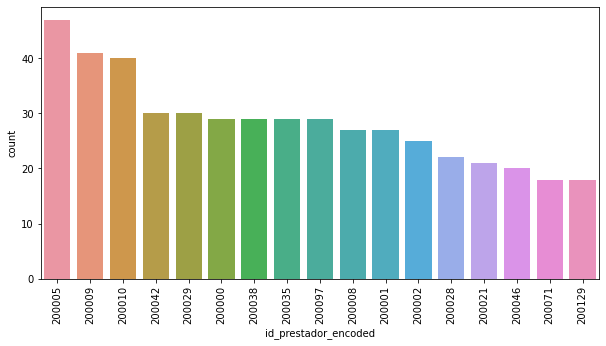

In [140]:
plt.figure(figsize=(10,5))
sns.countplot(df_clinica.id_prestador_encoded,order=df_clinica.id_prestador_encoded.value_counts().index)
plt.xticks(rotation=90)
plt.show()

No existe una desproporción en las clases como tal, por lo cual no será necesario un balanceo.

### División del dataframe en entrenamiento y validación

In [141]:
X=df_clinica.drop(['id_prestador_encoded'],axis=1)
y=df_clinica.id_prestador_encoded

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)

### Modelado y optimización de hiperparámetros

Vamos a hacer un GridSearch con CV, buscando la combinación de hiperparámetros que arroje mejores resultados para la métrica elegida (accuracy score)

In [142]:
dt = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')
rf=RandomForestClassifier(random_state=0,class_weight='balanced')
knn_clf=KNeighborsClassifier()

models_parameters= {'decision_tree': (dt,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__criterion': ['gini','entropy']})
                       ,'randonforest': (rf,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__n_estimators':[50,100,150,200,300],
                      'estimator__criterion': ['gini','entropy']})
                        ,'kneighbors': (knn_clf,
                     {'estimator__n_neighbors':[3,5,10],
                        'estimator__weights':['uniform','distance'],
                        'estimator__metric':['euclidean','manhattan','minkowski']})
                   }

In [143]:
for name, (model, params) in models_parameters.items():

    model_to_set = OneVsRestClassifier(model)

    gs=GridSearchCV(model_to_set,params,n_jobs=-1,cv=5,scoring='f1_macro')

    gs.fit(X_train,y_train)
    
    print(name)
    print(gs.best_score_)
    print(gs.best_params_)

decision_tree
0.07943273606540771
{'estimator__criterion': 'gini', 'estimator__max_depth': 10}
randonforest
0.12346819118643367
{'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__n_estimators': 200}
kneighbors
0.10724204992280024
{'estimator__metric': 'euclidean', 'estimator__n_neighbors': 10, 'estimator__weights': 'uniform'}


In [112]:
for name, (model, params) in models_parameters.items():

    model_to_set = OneVsRestClassifier(model)

    gs=GridSearchCV(model_to_set,params,n_jobs=-1,cv=5,scoring='f1_macro')

    gs.fit(X_train,y_train)
    
    print(name)
    print(gs.best_score_)
    print(gs.best_params_)

decision_tree
0.17831532204415104
{'estimator__criterion': 'entropy', 'estimator__max_depth': 4}
randonforest
0.20426427737664307
{'estimator__criterion': 'entropy', 'estimator__max_depth': 3, 'estimator__n_estimators': 150}
kneighbors
0.1413254370034239
{'estimator__metric': 'manhattan', 'estimator__n_neighbors': 10, 'estimator__weights': 'uniform'}


#### Mejores resultados y mejores parámetros

In [87]:
gs.best_score_

0.13856594042352557

In [88]:
gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

### Validación

In [92]:
knn_clf_best = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')
knn_clf_best.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [93]:
y_pred_train=knn_clf_best.predict(X_train)
y_pred_test=knn_clf_best.predict(X_test)

In [97]:
pd.DataFrame(classification_report(y_test,y_pred_test, output_dict=True)).T

C:\Users\arrua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
200000,0.5000,0.3333,0.4000,3.0000
200001,0.1667,0.3333,0.2222,3.0000
200002,0.5000,0.5000,0.5000,2.0000
200005,0.3333,0.4000,0.3636,5.0000
200008,0.5000,0.3333,0.4000,3.0000
200009,0.4000,0.5000,0.4444,4.0000
200010,0.2000,0.2500,0.2222,4.0000
200021,0.0000,0.0000,0.0000,2.0000
200028,0.0000,0.0000,0.0000,2.0000
200029,0.1667,0.3333,0.2222,3.0000


In [66]:
y_test.shape

(49,)

In [67]:
y_pred_test

array([200029, 200021, 200038, 200021, 200071, 200005, 200071, 200097,
       200035, 200010, 200005, 200005, 200008, 200071, 200046, 200042,
       200009, 200029, 200071, 200038, 200129, 200038, 200029, 200021,
       200010, 200010, 200008, 200028, 200129, 200029, 200002, 200029,
       200029, 200005, 200000, 200038, 200029, 200035, 200038, 200028,
       200035, 200021, 200001, 200005, 200005, 200042, 200029, 200038,
       200035], dtype=int64)

In [78]:
y_test.values

array([200046, 200129, 200009, 200097, 200029, 200008, 200042, 200071,
       200129, 200010, 200000, 200009, 200129, 200035, 200010, 200071,
       200005, 200001, 200021, 200005, 200021, 200129, 200029, 200097,
       200001, 200008, 200129, 200129, 200002, 200002, 200002, 200097,
       200097, 200002, 200000, 200000, 200005, 200005, 200038, 200046,
       200008, 200010, 200001, 200097, 200000, 200002, 200002, 200005,
       200097], dtype=int64)